Report of the Individual Assignment


**Smart Industry Operations**






Submitted by :

**Krisna Gopal Das**

Student ID: **S5024021**




*Faculty of Economics and Business*

**University of Groningen**


Date of Submission : 18 December, 2022


# 1. Introduction
This report has been prepared as a requirement of Smart Industry Operations course. This is related to an individual assignment where we are required to help Variass (manufacturer and supplier of advanced electronics parts to different industries) in predicting the defect rates of assembled products based on their specifications. Variass has provided us four (04) data files that will be needed and helpful in this assignment.

In this assignment, firstly, we need to check the data that have been provided to us, clean the data where it is needed and make those data suitable to be used for further analysis.

Then we need to determine the defect rates returned by the automated inspection system on the overall and per defect type. We also need to find the true defect rates and false calls’ rate in this step.

Then we need to develop  a  single  model  that  predicts  the  defect  rate  per  two  specific  defect  types. We also need to split the data in two portions where 80% of the inspection data should be used for training and the rest 20% should be used for testing for validation.

So in this report, the above mentioned order has been followed and the report is comprised of the following chapters sequentially:

•	Introduction (current section)

•	Data Cleaning and Preparation

•	Estimation of Defect Rates

•	Prediction and Performance Reporting

•	Recommendation and Conclusion



# 2. Data Cleaning and Preparation

In this part, we will clean, organize and make the provided data suitable for further analysis.

So at first, we need to import all necessary libraries here.

In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

We have four raw data files provided by Variass. These are:

AOI defects last year.csv

VPL list.xlsx

Order picklists.xlsx

Alternatives.xlsx

We will import data from these four files into four raw dataframes as shown below:

In [ ]:
raw_defect_df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/AOI defects last year.csv',encoding='latin1')
raw_vpl_parts_df = pd.read_excel(r'/content/drive/MyDrive/Colab Notebooks/VPL list.xlsx')
raw_orders_df = pd.read_excel(r'/content/drive/MyDrive/Colab Notebooks/Order picklists.xlsx')
raw_alternative_df = pd.read_excel(r'/content/drive/MyDrive/Colab Notebooks/Alternatives.xlsx')

Now, we will start data preparation with the raw orders dataframe where we will get the quantity of parts produced based on their part numbers. Here, we need to store the quantities based on their part numbers in a new dataframe. We can then drop the order identification numbers column.

In [ ]:
raw_orders_df = raw_orders_df.rename({'part number': 'partnumber'}, axis=1)
orders_df = raw_orders_df.groupby(['partnumber']).sum().reset_index()
orders_df.drop('Order', inplace=True, axis=1)
orders_df.head(20)

,partnumber,total amount
0,4022.634.36651,16.0
1,AKQ-00015,96.0
2,AKQ-00021,170.0
3,AKQ-00022,15.0
4,AKQ-00024,60.0
5,APA-00010,60.0
6,AR5-00003,300.0
7,AR5-00005,990.0
8,AR5-00012,4817.0
9,AR5-00013,1395.0


Now we will work on the AOI defects list raw dataframe. We will need only three columns from this file - 'defecttypestring', 'partnumber' and 'reviewed'. So we create a new dataframe with only these three columns.

In [ ]:
defects_df = pd.DataFrame()
defects_df['defecttypestring'] = raw_defect_df['defecttypestring']
defects_df['partnumber'] = raw_defect_df['partnumber']
defects_df['reviewed'] = raw_defect_df['reviewed']
defects_df.head(20)

,defecttypestring,partnumber,reviewed
0,Missing,UHW-00003,1
1,Missing,IR9-00013,1
2,Missing,IR9-00013,1
3,Missing,IR9-00013,1
4,Missing,IR9-00013,1
5,Missing,UHW-00003,1
6,Missing,UHW-00003,1
7,Missing,IR9-00013,1
8,Missing,IR9-00013,1
9,Missing,IR9-00013,1


In the reviewed columns, there are three different values - 0, 1 and 2 where 1 represents "false  calls" (the defect detected by AOI is not actually present), 2 represents "true positive" (the defect detected by AOI is actually present) and O represent error or unwanted entries. So we remove 0s from the data and then create two more columns namely "true positive" and "false  calls".

In [ ]:
defects_df['reviewed'].replace(0, np.nan, inplace=True)
defects_df['true reviewed'] = [0] * len(defects_df)
defects_df['false call'] = defects_df['reviewed']
defects_df['true reviewed'] = defects_df['reviewed'] - 1
defects_df['true reviewed'].replace(0, np.nan, inplace=True)
defects_df['false call'].replace(2, np.nan, inplace=True)
defects_df.head(10)


,defecttypestring,partnumber,reviewed,true reviewed,false call
0,Missing,UHW-00003,1.0,NaN,1.0
1,Missing,IR9-00013,1.0,NaN,1.0
2,Missing,IR9-00013,1.0,NaN,1.0
3,Missing,IR9-00013,1.0,NaN,1.0
4,Missing,IR9-00013,1.0,NaN,1.0
5,Missing,UHW-00003,1.0,NaN,1.0
6,Missing,UHW-00003,1.0,NaN,1.0
7,Missing,IR9-00013,1.0,NaN,1.0
8,Missing,IR9-00013,1.0,NaN,1.0
9,Missing,IR9-00013,1.0,NaN,1.0


Then there are some rows with NaN values for the defecttypestring and partnumber columns. We remove those from out dataframe as a part of cleaning.

In [ ]:
defects_df['defecttypestring'].replace('', np.nan, inplace=True)
defects_df['partnumber'].replace('', np.nan, inplace=True)
defects_df.dropna(subset=['defecttypestring','partnumber'],inplace=True)

Then since both the defect types named 'tekort' and 'Tekort' represents the same defect, we replace all 'tekort' entries with 'Tekort'.

In [ ]:
defects_df['defecttypestring'].replace('tekort', 'Tekort', inplace=True)
defects_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983087 entries, 0 to 992951
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   defecttypestring  983087 non-null  object 
 1   partnumber        983087 non-null  object 
 2   reviewed          976636 non-null  float64
 3   true reviewed     737133 non-null  float64
 4   false call        239503 non-null  float64
dtypes: float64(3), object(2)
memory usage: 45.0+ MB


Then we merge the previously stored orders dataframe with the defect types dataframe based on the part numbers. Here, we intentionally drop the reviewed columns but before we store the data into a new dataframe to be used later. This is needed to get the accurate quantities of the part numbers.

In [ ]:
defects_df_temp = defects_df
defects_df_temp_grouped = defects_df_temp.groupby(['partnumber','defecttypestring']).count().reset_index()
defects_df.drop('reviewed', inplace=True, axis=1)
defects_df.drop('true reviewed', inplace=True, axis=1)
defects_df.drop('false call', inplace=True, axis=1)
order_defects_merged_df = pd.merge(orders_df,defects_df, on= 'partnumber',how='left')
order_defects_merged_df.head(10)

,partnumber,total amount,defecttypestring
0,4022.634.36651,16.0,NaN
1,AKQ-00015,96.0,Missing
2,AKQ-00015,96.0,Missing
3,AKQ-00015,96.0,Missing
4,AKQ-00015,96.0,Missing
5,AKQ-00015,96.0,Missing
6,AKQ-00015,96.0,Missing
7,AKQ-00015,96.0,Missing
8,AKQ-00015,96.0,Missing
9,AKQ-00015,96.0,Missing


Now we will work the third raw dataframe namely raw_vpl_parts_df. We will extract only two columns from the VPL package raw dataframe - 'VPLpackage' and 'partnumber' to a new dataframe as shown below:

In [ ]:
vpl_df = pd.DataFrame()
vpl_df['VPLpackage'] = raw_vpl_parts_df['VPLpackage']
vpl_df['partnumber'] = raw_vpl_parts_df['partnumber']

Then we merge this vpl package with the previously stored order_defects_merged dataframe based on the part numbers:

In [ ]:
order_defects_vpl_merged_df = pd.merge(vpl_df,order_defects_merged_df, on= 'partnumber',how='left')
df_temp = order_defects_vpl_merged_df.groupby(['VPLpackage','partnumber','total amount']).count().reset_index()
df_temp.drop('defecttypestring', inplace=True, axis=1)
df_1 = pd.merge(df_temp,defects_df_temp_grouped, on= 'partnumber',how='left')
df_1.dropna(subset=['defecttypestring'],inplace=True)
df_temp2 = df_1
df_1.head(20)

,VPLpackage,partnumber,total amount,defecttypestring,reviewed,true reviewed,false call
5,CBXD-C3/XP-L48W35T53,VBO-00114,200.0,InsufficientSolder,13.0,13.0,0.0
6,CBXD-C3/XP-L48W35T53,VBO-00115,200.0,InsufficientSolder,3.0,3.0,0.0
7,CBXD-C3/XP-L48W35T53,VBO-00147,640.0,InsufficientSolder,5.0,5.0,0.0
8,CBXD-C3/XP-L48W35T53,VBO-00147,640.0,Missing,32.0,22.0,10.0
9,CBXD-C3/XP-L48W35T53,VBO-00147,640.0,NoSolder,2.0,2.0,0.0
10,CBXD-C3/XP-L48W35T53,VBO-00147,640.0,Polarity,68.0,68.0,0.0
11,CBXD-C3/XP-L48W35T53,VBO-00147,640.0,Tilt,17.0,17.0,0.0
12,CBXD-C3/XP-L48W35T53,VBO-00148,720.0,InsufficientSolder,6.0,6.0,0.0
13,CBXD-C3/XP-L48W35T53,VBO-00148,720.0,Missing,1.0,1.0,0.0
14,CBXD-C3/XP-L48W35T53,VBO-00148,720.0,Polarity,18.0,18.0,0.0


Finally we work on the alternatives raw dataframe and replace all the alternative part numbers with original part numbers from our current dataframe.

In [ ]:
for i in range(len(raw_alternative_df)):
    df_1['partnumber'].replace(raw_alternative_df.iloc[i,2], raw_alternative_df.iloc[i,0], inplace=True)


Then we extract the material types, lengths, widths and heights from the VPL codes:

In [ ]:
df_1['Material type'] = df_1['VPLpackage'].str[0]
df_1['Length'] = df_1['VPLpackage'].str.extract(pat = '[L](\d+)')
df_1['Width'] = df_1['VPLpackage'].str.extract(pat = '[W](\d+)')
df_1['Thickness'] = df_1['VPLpackage'].str.extract(pat = '[T](\d+)')
df_1.head(20)

,VPLpackage,partnumber,total amount,defecttypestring,reviewed,true reviewed,false call,Material type,Length,Width,Thickness
5,CBXD-C3/XP-L48W35T53,VBO-00114,200.0,InsufficientSolder,13.0,13.0,0.0,C,48,35,53
6,CBXD-C3/XP-L48W35T53,VBO-00115,200.0,InsufficientSolder,3.0,3.0,0.0,C,48,35,53
7,CBXD-C3/XP-L48W35T53,VBO-00147,640.0,InsufficientSolder,5.0,5.0,0.0,C,48,35,53
8,CBXD-C3/XP-L48W35T53,VBO-00147,640.0,Missing,32.0,22.0,10.0,C,48,35,53
9,CBXD-C3/XP-L48W35T53,VBO-00147,640.0,NoSolder,2.0,2.0,0.0,C,48,35,53
10,CBXD-C3/XP-L48W35T53,VBO-00147,640.0,Polarity,68.0,68.0,0.0,C,48,35,53
11,CBXD-C3/XP-L48W35T53,VBO-00147,640.0,Tilt,17.0,17.0,0.0,C,48,35,53
12,CBXD-C3/XP-L48W35T53,VBO-00148,720.0,InsufficientSolder,6.0,6.0,0.0,C,48,35,53
13,CBXD-C3/XP-L48W35T53,VBO-00148,720.0,Missing,1.0,1.0,0.0,C,48,35,53
14,CBXD-C3/XP-L48W35T53,VBO-00148,720.0,Polarity,18.0,18.0,0.0,C,48,35,53


Now we have found some cases where  the total number of orders are less than total number of defects detected by the AOI. For example, for part number XA32-00041, the no. of orders = 41 (as per raw orders file) but no. of detected defects: 60 (as per raw AOI defects file). This happened probably beacuse of some processing errors. However, we need to exclude those rows also for smooth defect type determination.

In [ ]:
final_df_grouped = df_1.groupby(['VPLpackage','Material type','Length','Width','Thickness','defecttypestring']).sum().reset_index()
indexAge = final_df_grouped[(final_df_grouped['total amount'] < final_df_grouped['reviewed'] )].index
final_df_grouped.drop(indexAge, inplace=True)

# 3. Estimation of Defect Rates

In this section, we will estimate the defect rates per defect types and per VPL package code, true defect rates and also false call rates - all detected by the AOI.

First, we determine the overall defect detection rate by the AOI and then the true detection rate and the false detection  rates. Then we plot the true and false call rates in a pie chart for better visualization.

total reviewed % is :  0.11295986272403848
true reviewed % is :  0.7589380968399663
false call % is :  0.24106190316003379


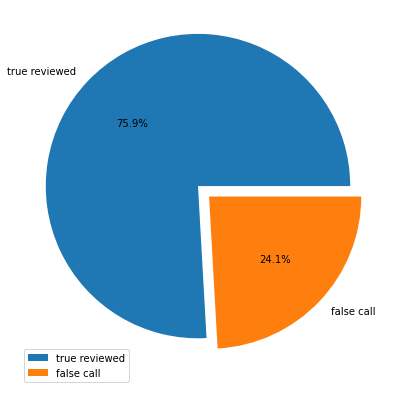

In [ ]:
sum1 = final_df_grouped['total amount'].sum()
sum2 = final_df_grouped['reviewed'].sum()
sum3 = final_df_grouped['true reviewed'].sum()
sum4 = final_df_grouped['false call'].sum()

print('total reviewed % is : ', (sum2 * 100/sum1))
print('true reviewed % is : ', (sum3/sum2))
print('false call % is : ', (sum4/sum2))

fig = plt.figure(figsize =(10, 7))
plt.pie([sum3/sum2,sum4/sum2], labels = ['true reviewed','false call'], explode = [0.1,0], autopct='%.1f%%')
plt.legend()

Here, we can see that only 0.11% of the total manufactured parts were found to be with defects by the AOI machine which is very small. So the overall manufacturing process can be assumed to be sufficiently efficient.

Then, if we look at the rate at which the AOI machine is able to detect the defects correctly, then we see that among all the defects detected by the AOI machine, around 76% are truely with defects and one-fourth of the detected items were not actually with defects. This means, the AOI mahcine, on average, makes one error in every four detected items. This may have seroius negative impact on both the AOI utilization and the Human-hour utilization of Variass.

Now, we want to determine the defect rates and drop the numbers columns from the current dataframe. We also drop now the part numbers column since we already have the corresponding VPL codes.

In [ ]:
final_df_grouped['defect_rate'] = final_df_grouped['reviewed'] /final_df_grouped['total amount'] * 100
final_df_grouped['true_defect_rate'] = final_df_grouped['true reviewed'] /final_df_grouped['total amount'] * 100
final_df_grouped['false call rate'] = final_df_grouped['false call'] /final_df_grouped['total amount'] * 100
final_df_grouped.drop('total amount', inplace=True, axis=1)
final_df_grouped.drop('reviewed', inplace=True, axis=1)
final_df_grouped.drop('true reviewed', inplace=True, axis=1)
final_df_grouped.drop('false call', inplace=True, axis=1)
final_df_grouped.head(10)

,VPLpackage,Material type,Length,Width,Thickness,defecttypestring,defect_rate,true_defect_rate,false call rate
0,CBXD-C3/XP-L48W35T53,C,48,35,53,InsufficientSolder,1.793478,1.793478,0.00000
1,CBXD-C3/XP-L48W35T53,C,48,35,53,Missing,2.289157,1.686747,0.60241
2,CBXD-C3/XP-L48W35T53,C,48,35,53,NoSolder,0.312500,0.312500,0.00000
3,CBXD-C3/XP-L48W35T53,C,48,35,53,Polarity,6.323529,6.323529,0.00000
4,CBXD-C3/XP-L48W35T53,C,48,35,53,Tilt,1.323529,1.323529,0.00000
5,CBXD-N4/JO-L70W50T14,C,70,50,14,InsufficientSolder,1.306413,1.306413,0.00000
6,CBXD-N4/JO-L70W50T14,C,70,50,14,Missing,0.332542,0.332542,0.00000
7,CDSO-N4/JX-L70W50T16,C,70,50,16,InsufficientSolder,9.166667,9.166667,0.00000
8,CDSO-N4/JX-L70W50T16,C,70,50,16,Missing,1.111111,1.111111,0.00000
9,CDXD-C2/XI-L120W120T80,C,120,120,80,Missing,93.000000,15.000000,78.00000


Here, we have determined the defect rates per type per VPL package code as required. We can check how many rows are there in this dataframe.

In [ ]:
final_df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6284 entries, 0 to 6404
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   VPLpackage        6284 non-null   object 
 1   Material type     6284 non-null   object 
 2   Length            6284 non-null   object 
 3   Width             6284 non-null   object 
 4   Thickness         6284 non-null   object 
 5   defecttypestring  6284 non-null   object 
 6   defect_rate       6284 non-null   float64
 7   true_defect_rate  6284 non-null   float64
 8   false call rate   6284 non-null   float64
dtypes: float64(3), object(6)
memory usage: 490.9+ KB


Now we create numerical attributes for every defect types:

In [ ]:
dummy_df = pd.get_dummies(final_df_grouped['defecttypestring'])
final_df= final_df_grouped.join(dummy_df)
final_df.head(10)


,VPLpackage,Material type,Length,Width,Thickness,defecttypestring,defect_rate,true_defect_rate,false call rate,Bridge,...,PitchShift,Polarity,Rotate,Shift,SolderBall,Tekort,Tilt,Tomstone,TurnOver,WrongPart
0,CBXD-C3/XP-L48W35T53,C,48,35,53,InsufficientSolder,1.793478,1.793478,0.00000,0,...,0,0,0,0,0,0,0,0,0,0
1,CBXD-C3/XP-L48W35T53,C,48,35,53,Missing,2.289157,1.686747,0.60241,0,...,0,0,0,0,0,0,0,0,0,0
2,CBXD-C3/XP-L48W35T53,C,48,35,53,NoSolder,0.312500,0.312500,0.00000,0,...,0,0,0,0,0,0,0,0,0,0
3,CBXD-C3/XP-L48W35T53,C,48,35,53,Polarity,6.323529,6.323529,0.00000,0,...,0,1,0,0,0,0,0,0,0,0
4,CBXD-C3/XP-L48W35T53,C,48,35,53,Tilt,1.323529,1.323529,0.00000,0,...,0,0,0,0,0,0,1,0,0,0
5,CBXD-N4/JO-L70W50T14,C,70,50,14,InsufficientSolder,1.306413,1.306413,0.00000,0,...,0,0,0,0,0,0,0,0,0,0
6,CBXD-N4/JO-L70W50T14,C,70,50,14,Missing,0.332542,0.332542,0.00000,0,...,0,0,0,0,0,0,0,0,0,0
7,CDSO-N4/JX-L70W50T16,C,70,50,16,InsufficientSolder,9.166667,9.166667,0.00000,0,...,0,0,0,0,0,0,0,0,0,0
8,CDSO-N4/JX-L70W50T16,C,70,50,16,Missing,1.111111,1.111111,0.00000,0,...,0,0,0,0,0,0,0,0,0,0
9,CDXD-C2/XI-L120W120T80,C,120,120,80,Missing,93.000000,15.000000,78.00000,0,...,0,0,0,0,0,0,0,0,0,0


If we sort the above dataframe according to the defect rate, then we can see which parts usually have more frequency to be produced with defects. The top five such parts with their defect rates are found below:

In [ ]:
final_df_temp = final_df.sort_values(by = ['defect_rate'], ascending=False)
final_df_temp[['VPLpackage','defect_rate']]

,VPLpackage,defect_rate
3561,PDXC-F2/XS-L328W160T75,100.000000
921,MSXC-F11/NU-L75W50T25,100.000000
4274,PDXS-G4/HD-L73W79T91,97.500000
5299,PSXC-N3/HH-L76W18T65,96.666667
4738,PQFP-N21/MX-L30W30T6,95.454545
...,...,...
442,CDXD-R2/XR-L10W5T3,0.000066
6221,XDXD-R2/XR-L65W34T7,0.000000
6212,XDXD-R2/XR-L51W25T6,0.000000
3268,PDSO-N33/LX-L70W40T8,0.000000


Now we will determine the defect rates, true defect rates and false call rates detected by the AOI machine per defect type. For this, we will use a temporary dataframe where we stored the necessary data previously. We will now drop two unnecssary columns from this temporary dataframe and then determine all required defect rates per defect type.

We can also determine the defect detection rate percentage per defect type and also the percentages of true detection and false detection among the detected defects.

In [ ]:
df_temp2.drop('VPLpackage', inplace=True, axis=1)
df_temp2.drop('partnumber', inplace=True, axis=1)
df_new = df_temp2.groupby(['defecttypestring']).sum().reset_index()
df_new['reviewed % per defect type'] = df_new['reviewed'] * 100 / df_new['total amount']
df_new['true reviewed % per defect type'] = df_new['true reviewed'] * 100 / df_new['reviewed']
df_new['false call % per defect type'] = df_new['false call'] * 100 / df_new['reviewed']
df_new[['defecttypestring','total amount','reviewed','true reviewed','false call','reviewed % per defect type','true reviewed % per defect type','false call % per defect type']]

,defecttypestring,total amount,reviewed,true reviewed,false call,reviewed % per defect type,true reviewed % per defect type,false call % per defect type
0,Bridge,36134515.0,26678.0,19753.0,6925.0,0.073830,74.042282,25.957718
1,ChipFlying,2321208.0,151.0,129.0,22.0,0.006505,85.430464,14.569536
2,ColdSolder,1316320.0,1490.0,1314.0,176.0,0.113194,88.187919,11.812081
3,Damage,30297648.0,1109.0,9.0,1100.0,0.003660,0.811542,99.188458
4,DoubleChip,5366811.0,53.0,52.0,1.0,0.000988,98.113208,1.886792
5,ExcessSolder,33737945.0,1601.0,69.0,1532.0,0.004745,4.309806,95.690194
6,ForeignMaterial,22665474.0,331.0,2.0,329.0,0.001460,0.604230,99.395770
7,InsufficientSolder,66304095.0,334257.0,306985.0,27272.0,0.504127,91.841009,8.158991
8,LiftedLead,11872777.0,43110.0,37768.0,5342.0,0.363100,87.608444,12.391556
9,LiftedPackage,58511144.0,23818.0,1672.0,22146.0,0.040707,7.019901,92.980099


Here, we can see that the  prediction by the AOI machine is highest successfull for the defect type "LiftedSolder" where all the reviewed parts were actually found to be with defects. Apart from this defect type, "DoubleChip", "InsufficientSolder", "OutofArea", "PinHole" also have successful detection rates over 90%.

One more thing to notice here that, "InsufficientSolder" and "Missing" are the two most frequently detected defect types by the AOI machine, both with large number of defects found with compared to other defects types.

Here, it can also be mentioned we have got few points of concern which may call for further exploration.

First, we get some parts where the total number of orders are less than total number of defects detected by the AOI which is clearly unexpected. The number of defected parts cannot be greater than the total number of manufactured parts. For example, for part number XA32-00041, the total no. of orders = 41 (as per raw orders file) but no. of detected defects: 60 (as per raw AOI defects file).

Also for part number XA32-00029, there was no orders at all i.e. the the total no. of orders = 0 (as per raw orders file) but no. of detected defects: 6 (as per raw AOI defects file).

The reason behind this can be both these files donot contain data of the same time period. However, this is something that definitely needs explanation.

Then, another point to mention is that the part numbers and their VPL package codes were found not as unique. Some part numbers have more that one VPL package code which created difficulties in calculations.

For example, for part number CAX-00001, we got two VPL codes as PBXC-G60/MB-L172W40T25 and PDXC-G62/MB-L189W56T21. This obviously created difficulties in calculations. This also needs to be checked..

# 4. Prediction and Performance Reporting

In this part of report, we will first prepare our data for developing a model to determine if there is any relationship between the defect rates of two defect types - 'Shift' and 'Rotate' and the physical specifications.

For this reason, we first prepare our data by keeping only two defect types and dropping all others from our current dataframe.

In [ ]:
final_df_grouped_2 = final_df_grouped
indexAge = final_df_grouped[(final_df_grouped['defecttypestring'] != 'Shift')].index
final_df_grouped = final_df_grouped.drop(indexAge)
index2 = final_df_grouped_2[(final_df_grouped_2['defecttypestring'] != 'Rotate')].index
final_df_grouped_2 = final_df_grouped_2.drop(index2)
final_df_grouped = final_df_grouped.append(final_df_grouped_2,ignore_index=True)
dummy_df = pd.get_dummies(final_df_grouped['defecttypestring'])
final_df= final_df_grouped.join(dummy_df)
dummy_df = pd.get_dummies(final_df['Material type'])
final_df = final_df.join(dummy_df)

In [ ]:
final_df.head()

,VPLpackage,Material type,Length,Width,Thickness,defecttypestring,defect_rate,true_defect_rate,false call rate,Rotate,Shift,C,L,M,P,X
0,CDXD-R2/XC-L10W5T3,C,10,5,3,Shift,0.002479,0.002479,0.000000,0,1,1,0,0,0,0
1,CDXD-R2/XC-L10W5T5,C,10,5,5,Shift,0.003187,0.000015,0.003172,0,1,1,0,0,0,0
2,CDXD-R2/XC-L10W5T6,C,10,5,6,Shift,0.005136,0.000428,0.004708,0,1,1,0,0,0,0
3,CDXD-R2/XC-L16W8T8,C,16,8,8,Shift,0.009507,0.000762,0.008744,0,1,1,0,0,0,0
4,CDXD-R2/XC-L16W8T9,C,16,8,9,Shift,0.000485,0.000162,0.000323,0,1,1,0,0,0,0


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   VPLpackage        618 non-null    object 
 1   Material type     618 non-null    object 
 2   Length            618 non-null    object 
 3   Width             618 non-null    object 
 4   Thickness         618 non-null    object 
 5   defecttypestring  618 non-null    object 
 6   defect_rate       618 non-null    float64
 7   true_defect_rate  618 non-null    float64
 8   false call rate   618 non-null    float64
 9   Rotate            618 non-null    uint8  
 10  Shift             618 non-null    uint8  
 11  C                 618 non-null    uint8  
 12  L                 618 non-null    uint8  
 13  M                 618 non-null    uint8  
 14  P                 618 non-null    uint8  
 15  X                 618 non-null    uint8  
dtypes: float64(3), object(6), uint8(7)
memory us

Now we strat with the regression model developing. Here, we have choosen the "Decision Tree" regression model to be used.

First, we will check with 'Shift' type of defects to see if the model can predict accurately the defect rates based on the relationships between the defect rate of 'Shift' and the physical specifications of the parts that have this defect.

In [ ]:
X1= final_df[["Shift","C","L","M","P","X","Length","Width","Thickness"]].values
Y1= final_df["true_defect_rate"].values
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X1, Y1)
y_pred = regressor.predict(X1)
df = pd.DataFrame({'Actual':Y1, 'Predicted':y_pred})
print("--------------------------------- For Shift ------------------------------------------")
print('Mean Absolute Error:', mean_absolute_error(Y1, y_pred))
print('Mean Squared Error:', mean_squared_error(Y1, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y1, y_pred)))
print("Coefficient of determination:",r2_score(Y1,y_pred))

--------------------------------- For Shift ------------------------------------------
Mean Absolute Error: 0.006490142248487392
Mean Squared Error: 0.0028174314178690744
Root Mean Squared Error: 0.053079482079887275
Coefficient of determination: 0.997157257789906


Here, we see that all the MAE, MSE and RMSE values are close to zero. Moreover, the R-square value (Coefficient of determination) is also close to one. So based on all these metrices, it can be said that the model is sufficiently fit to predict the defect rates based on the relationships between the defect rate of 'Shift' and the physical specifications of the parts that have this defect. So it can also be said that there is a significant relationship between the defect rate of 'Shift' and the physical specifications of the parts that have this defect.

Then, we will check with 'Rotate' type of defects to see if the model can predict accurately the defect rates based on the relationships between the defect rate of 'Rotate' and the physical specifications of the parts that have this defect.

In [ ]:
X1= final_df[["Rotate","C","L","M","P","X","Length","Width","Thickness"]].values
Y1= final_df["true_defect_rate"].values
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X1, Y1)
y_pred = regressor.predict(X1)
df = pd.DataFrame({'Actual':Y1, 'Predicted':y_pred})
print("--------------------------------- For Rotate ------------------------------------------")
print('Mean Absolute Error:', mean_absolute_error(Y1, y_pred))
print('Mean Squared Error:', mean_squared_error(Y1, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y1, y_pred)))
print("Coefficient of determination:",r2_score(Y1,y_pred))

--------------------------------- For Rotate ------------------------------------------
Mean Absolute Error: 0.006490142248487392
Mean Squared Error: 0.0028174314178690744
Root Mean Squared Error: 0.053079482079887275
Coefficient of determination: 0.997157257789906


Here, in case of 'Rotate' type of defect also, we find that all the MAE, MSE and RMSE values are close to zero. Moreover, the R-square value (Coefficient of determination) is also close to one. So based on all these metrices, it can be said that the model is sufficiently fit to predict the defect rates based on the relationships between the defect rate of 'Rotate' and the physical specifications of the parts that have this defect. So it can also be said that there is a significant relationship between the defect rate of 'Rotate' and the physical specifications of the parts that have this defect.

Now we will spilt the total data in two parts - 80% for training purpose and the rest 20% for test validation purpose.

So again we start with 'Shift' defect type and try to fit the model using model predictions and also plot the regression line.

--------------------------------- For Shift with Splitted Data ------------------------------------------
Mean Absolute Error: 0.29420169465212076
Mean Squared Error: 1.4489861243009277
Root Mean Squared Error: 1.203738395292319
Coefficient of determination: -3.8549533556776883


Text(0.5, 1.0, 'For Shift with Splitted Data')

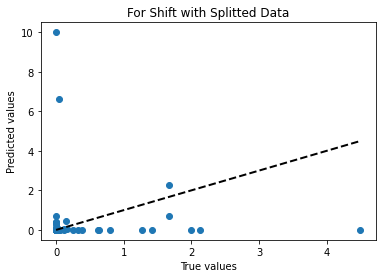

In [ ]:
X1= final_df[["Shift","C","L","M","P","X","Length","Width","Thickness"]].values
Y1= final_df["true_defect_rate"].values
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size = .20, random_state = 0)
regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)
print("--------------------------------- For Shift with Splitted Data ------------------------------------------")
df=pd.DataFrame({'Actual':Y_test, 'Predicted':y_pred})
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
print("Coefficient of determination:",r2_score(Y_test,y_pred))
fig, axes = plt.subplots(1)
plt.scatter(Y_test, y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('For Shift with Splitted Data')

Here, we find that MAE, MSE and RMSE values are considerably close to zero. Therefore, based on these three metrices it seems that the regression model can be considered as a good fit. But at the same time, we get a negative value for the R-square value (Coefficient of determination) which indicates that the chosen model does not follow the trend of the data. And also from the graph it is evident that, the regresion line cannot be considered to be a good fit.

Then we continue doing the same with 'Rotate' defect type and try to fit the model using model predictions and also plot the regression line.

--------------------------------- For Rotate with Splitted Data ------------------------------------------
Mean Absolute Error: 0.29185575454867035
Mean Squared Error: 1.448178166085704
Root Mean Squared Error: 1.203402744755763
Coefficient of determination: -3.8522462217842293


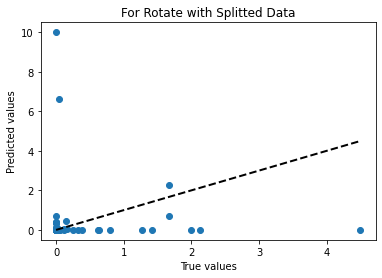

In [ ]:
X1= final_df[["Rotate","C","L","M","P","X","Length","Width","Thickness"]].values
Y1= final_df["true_defect_rate"].values
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size = .20, random_state = 0)
regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)
print("--------------------------------- For Rotate with Splitted Data ------------------------------------------")
df=pd.DataFrame({'Actual':Y_test, 'Predicted':y_pred})
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
print("Coefficient of determination:",r2_score(Y_test,y_pred))

fig, axes = plt.subplots(1)
plt.scatter(Y_test, y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('For Rotate with Splitted Data')
plt.show()

Here, we get similar results for 'Rotate' defect type also. We find that MAE, MSE and RMSE values are considerably close to zero. Therefore, based on these three metrices it seems that the regression model can be considered as a good fit. But at the same time, we get a negative value for the R-square value (Coefficient of determination) which indicates that the chosen model does not follow the trend of the data. And also from the graph it is evident that, the regresion line cannot be considered to be a good fit.

# 5. Recommendation and Conclusion



In this assignment, with a view to helping Variass, we have determined the defects detection rate of the manufactured electronic parts based on various metrices. Then we have also tried to predict if the defects type have any relationships with the physical specifications of the parts. In this process, we have used the "Decision tree" regression since it was found to be able to predict the defect rates best when compared with other regression models.

The findings and recommendations are summarized below:

1. The five parts' with highest defect rates detected by the AOI machine are mentioned below with their following VPL package codes:

  PDXC-F2/XS-L328W160T75
  
  MSXC-F11/NU-L75W50T25
  
  PDXS-G4/HD-L73W79T91
  
  PSXC-N3/HH-L76W18T65
  
  PQFP-N21/MX-L30W30T6


2. Only 0.11% of the total manufactured parts were found to be with defects by the AOI machine which is very small. So the overall manufacturing process can be considered to be sufficiently efficient.

3. The probability that the AOI machine will correctly detect defects in all manufactured parts is 0.76 which means the AOI mahcine, on average, makes one error in every four detected items. If the accuracy of this machine can be improved, then it may result in higher available machine and human hours.

4. "InsufficientSolder" and "Missing" are the two most frequently detected defect types by the AOI machine. So measures should be taken to avoid these defects during the production precoess.

5. The  prediction by the AOI machine is highest successfull for the defect type "LiftedSolder" where all the reviewed parts were actually found to be with defects. Apart from this defect type, "DoubleChip", "InsufficientSolder", "OutofArea", "PinHole" also have successful detection rates over 90%.

To conclude, I would say that this assignment had been an excellent opportunity for me to explore and learn various avenues of python programming and big data handling and analysis through solving a real life problem. It is always fun and very effective to learn through solving projects inspired from real life problems.

I firmly believe that the interest which this course has created inside me towards python programming and solving operations management problems using different programming tools will definitely keep pushing me to explore more and more realms of technology.  